In [1]:
!pip install datasets
!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL

import pandas as pd
import logging
from datasets import Dataset
import os
import optuna
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, BertTokenizer
from transformers import set_seed
import random

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
seed = 0
set_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
dir = "/content/drive/MyDrive/Colab/thesis"

In [4]:
class DataLoader:
    def __init__(self, tokenizer, device='cpu', max_length=512):
        """
        Initialize the data loader.

        Parameters:
        - tokenizer: Hugging Face tokenizer.
        - device (str): Device to load the tensors onto.
        - max_length (int): Max sequence length for padding/truncation.
        """
        self.tokenizer = tokenizer
        self.device = device
        self.max_length = max_length

    def tokenize(self, texts):
        """
        Tokenize a list of text samples.

        Parameters:
        - texts (list): List of strings.

        Return:
        - dict: Tokenized inputs as tensors on the specified device.
        """
        tokenized = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        ).to(self.device)

        return tokenized

    def load(self, data, labels=None):
        """
        Load and return a Hugging Face Dataset object.

        Parameters:
        - data (list): List of input texts.
        - labels (list, optional): Labels corresponding to the input texts.

        Return:
        - Dataset: Hugging Face Dataset object with tokenized inputs.
        """
        tokenized = self.tokenize(data)

        if labels is not None:
            tokenized = {**tokenized, 'labels': torch.tensor(labels).to(self.device)}

        dataset_dict = {k: v.cpu() for k, v in tokenized.items()}
        hf_dataset = Dataset.from_dict(dataset_dict)

        return hf_dataset

# EXIST

In [5]:
ds_name = "EXIST2024"
exist_training_data = "".join([dir, "/data/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/EXIST2024/EXIST2024_validation.json"])
exist_test_data = "".join([dir, "/data/EXIST2024/EXIST2024_test.json"])

In [6]:
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

## Binary Classification: Sexist vs. non-sexist

In [7]:
evaluation_type = "binary"
#division and processing of data as input to the model
X_train = exist_train_df["bert representation"].tolist()
y_train = exist_train_df["sexist"].tolist()
X_dev = exist_dev_df["bert representation"].tolist()
y_dev = exist_dev_df["sexist"].tolist()
X_test = exist_test_df["bert representation"].tolist()
y_test = exist_test_df["sexist"].tolist()

In [8]:
#load bert model and tokenizer
model, tokenizer, device = load_model()
data_loader = DataLoader(tokenizer, device=device)
#tokenize data and format as dataset dict for fine-tuning
train_data = data_loader.load(X_train, y_train)
dev_data = data_loader.load(X_dev, y_dev)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
###hyperparameter tuning with Optuna as seen at https://python-bloggers.com/2022/08/hyperparameter-tuning-a-transformer-with-optuna/

task = "sexism-identification"
model_name = "bert-base-uncased"

# Project constants
LR_MIN = 5e-6
LR_CEIL = 1e-4
WD_MIN = 1e-6
WD_CEIL = 0.01
MIN_EPOCHS = 2
MAX_EPOCHS = 10
#PER_DEVICE_EVAL_BATCH = 8
#PER_DEVICE_TRAIN_BATCH = 8
NUM_TRIALS = 3
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bert/{model_name}-{task}"
NAME_OF_MODEL = model_name
#MAX_LENGTH = 512

def objective(trial: optuna.Trial) -> float:

    batch_size = trial.suggest_categorical("batch_size", [8,16,32,64])

    training_args = TrainingArguments(
        output_dir=SAVE_DIR,
        learning_rate=trial.suggest_float('learning_rate', low=LR_MIN, high=LR_CEIL,log=True),
        weight_decay=trial.suggest_float('weight_decay', WD_MIN, WD_CEIL,log=True),
        num_train_epochs=trial.suggest_int('num_train_epochs', low = MIN_EPOCHS,high = MAX_EPOCHS),
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
        #disable_tqdm=True
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
        )

    result = trainer.train()
    return result.training_loss

In [ ]:
print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-bert', direction='minimize')
study.optimize(objective, n_trials=NUM_TRIALS)

# This can be used to train the final model. Passed through using kwargs into the model
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])
best_batch_size = int(study.best_params['batch_size'])

print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')
print(f'The best batch size is: {best_batch_size}')


[I 2025-04-02 14:59:14,582] A new study created in memory with name: hp-search-bert


Triggering Optuna study


<ipython-input-7-4e37f76d1660>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


[I 2025-04-02 15:00:08,998] Trial 0 finished with value: 0.6202555136247114 and parameters: {'batch_size': 32, 'learning_rate': 4.5390342650337355e-05, 'weight_decay': 0.0001328309524764892, 'num_train_epochs': 2}. Best is trial 0 with value: 0.6202555136247114.
<ipython-input-7-4e37f76d1660>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.213000


[I 2025-04-02 15:04:46,413] Trial 1 finished with value: 0.12447311316413441 and parameters: {'batch_size': 16, 'learning_rate': 2.339059292522288e-05, 'weight_decay': 2.1428757458272296e-06, 'num_train_epochs': 10}. Best is trial 1 with value: 0.12447311316413441.
<ipython-input-7-4e37f76d1660>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


[I 2025-04-02 15:06:28,889] Trial 2 finished with value: 0.0014921704476529901 and parameters: {'batch_size': 64, 'learning_rate': 1.2839086807801085e-05, 'weight_decay': 4.563761079092192e-05, 'num_train_epochs': 4}. Best is trial 2 with value: 0.0014921704476529901.


Finding study best parameters
Extract best study params
The best learning rate is: 1.2839086807801085e-05
The best weight decay is: 4.563761079092192e-05
The best epoch is : 4
The best batch size is: 64


In [ ]:
task = "sexism-identification"
model_name = "bert-base-uncased"
SAVE_DIR = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bert/{model_name}-{task}"

print('Training the model on the custom parameters')

args = TrainingArguments(
        output_dir=SAVE_DIR,
        evaluation_strategy="epoch",
        learning_rate=best_lr,
        per_device_train_batch_size=best_batch_size,
        per_device_eval_batch_size=best_batch_size,
        num_train_epochs=best_epoch,
        weight_decay=best_weight_decay,
        report_to="none",
        save_strategy="no",
        metric_for_best_model="eval_f1"
    )

trainer = Trainer(
        model,
        args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
result = trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-d11c82e16022>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training the model on the custom parameters


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,2.446093,0.746633,0.725771,0.724058
2,No log,2.484197,0.728571,0.721918,0.722059
3,No log,2.341283,0.755556,0.748116,0.748529
4,No log,2.350789,0.738172,0.727568,0.727368


In [ ]:
trainer.evaluate()

{'eval_loss': 2.3507885932922363,
 'eval_precision': 0.7381720430107528,
 'eval_recall': 0.727568493150685,
 'eval_f1': 0.7273675518275458,
 'eval_runtime': 0.9964,
 'eval_samples_per_second': 153.56,
 'eval_steps_per_second': 3.011,
 'epoch': 4.0}

In [ ]:
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bert/{model_name}-{task}"
tokenizer.save_pretrained(model_dir+"/tokenizer")
trainer.save_model(model_dir+"/trainer")
model.save_pretrained(model_dir+"/model")

In [ ]:
# testing fine-tuned model for sexism identification

In [9]:
#loading fine-tuned model and tokenizer
evaluation_type = "binary"
task = "sexism-identification"
model_name = "bert-base-uncased"
model_dir = dir + f"/models/in_domain/{ds_name}/{evaluation_type}/bert/{model_name}-{task}"
sexism_id_model = AutoModelForSequenceClassification.from_pretrained(model_dir+"/model")
sexism_id_tokenizer = AutoTokenizer.from_pretrained(model_dir+"/tokenizer")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sexism_id_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
#make predictions on dev data
y_pred = exist_dev_df["bert representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Saved EXIST2024 validation split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bert_EXIST2024_validation_binary.json
Saved EXIST2024 validation split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bert_EXIST2024_validation_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for BERT:
              precision    recall  f1-score   support

  non-sexist       0.77      0.63      0.69        73
      sexist       0.71      0.82      0.76        80

    accuracy                           0.73       153
   macro avg       0.74      0.73      0.73       153
weighted avg       0.74      0.73      0.73       153

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix for 

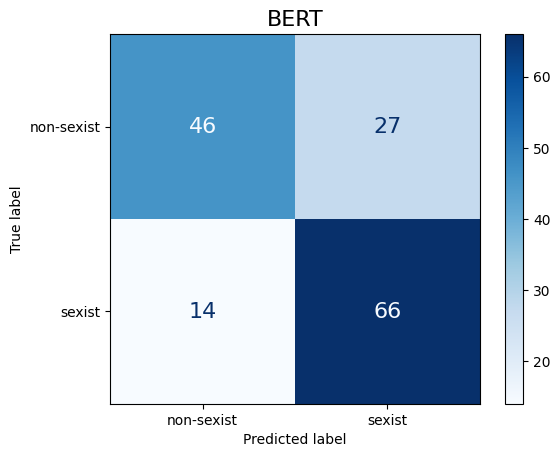

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for BERT:

2025-07-15 08:16:51,067 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-07-15 08:16:51,918 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:16:51,973 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-07-15 08:16:51,975 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:16:52,028 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-07-15 08:16:52,083 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
cargado 29
This is a table PyEvA

In [11]:
gold_path_dev_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_{evaluation_type}.json"
gold_dev_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_validation_truth.txt"
#create file with predictions
dev_pred_json,dev_pred_txt = save_evaluation(exist_dev_df, dir+"/models/evaluation/predictions", ds_name, "validation", evaluation_type, "bert", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_dev_binary,dev_pred_json,
                               y_dev,y_pred,
                                ["non-sexist","sexist"],
                               gold_dev_txt,dev_pred_txt,
                               model_name="BERT")

In [ ]:
#make predictions on test data
y_pred = exist_test_df["bert representation"].apply(lambda x: classify_text(x, sexism_id_model, sexism_id_tokenizer, device))

Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bert_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/bert_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for BERT:
              precision    recall  f1-score   support

  non-sexist       0.70      0.61      0.65        76
      sexist       0.71      0.79      0.75        95

    accuracy                           0.71       171
   macro avg       0.71      0.70      0.70       171
weighted avg       0.71      0.71      0.70       171

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix for BERT:


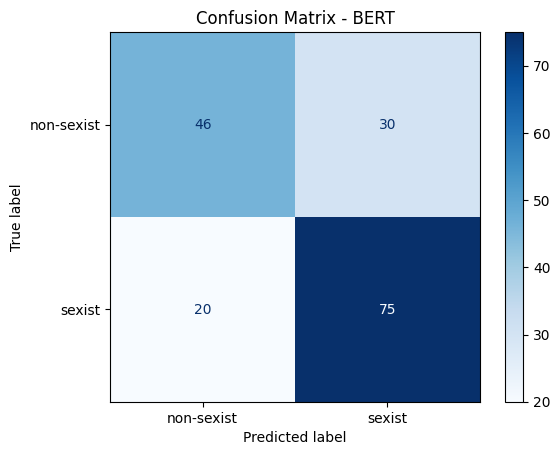

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for BERT:

2025-04-10 19:40:53,160 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-04-10 19:40:53,416 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 19:40:53,474 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-04-10 19:40:53,476 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 19:40:53,533 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 19:40:53,590 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
This is a table PyEvALL report, 

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "bert", y_pred, "sexist", [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="BERT")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/bert_{ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred.to_numpy(), ["sexist"], output_path)

Predictions saved to /content/drive/MyDrive/Colab/thesis/models/output/EXIST2024/bert_EXIST2024_test_binary.csv
